In [1]:
import sys
sys.path.append("../")

import matplotlib.pyplot as plt
import numpy as np
from src.loaders import load_data, load_labels
from src.classify import MCM_Classifier
import os
import src.plot as myplot
import scipy.ndimage as ndi

In [2]:
import importlib
import src.plot as myplot
importlib.reload(myplot)

<module 'src.plot' from '/Users/paulhosek/PycharmProjects/mcm/MCM_classifier/Classifier_1/classifier/bin/../src/plot.py'>

In [3]:
# Customizable environment variables
n_categories = 10  # Number of categories to be classified
n_variables = 121  # Number of variables in the dataset
mcm_filename_format = "train-images-unlabeled-{}_bootstrap_comms.dat"
data_filename_format = "train-images-unlabeled-{}.dat"
data_path = "../all_INPUT/data/"
communities_path = "../OUTPUT/comms/"
output_path = "../OUTPUT/"

In [4]:
print("{:-^50}".format("  MCM-Classifier  ")) 

# test_data = load_data("../INPUT/data/test-images-unlabeled-all-uniform.txt").astype(int)
# test_labels = load_labels("../INPUT/data/test-labels-uniform.txt").astype(int)

# Step 1: Initialize classifier
classifier = MCM_Classifier(n_categories, n_variables, mcm_filename_format, data_filename_format, data_path, communities_path)

# Step 2: Train
classifier.fit(greedy=True, max_iter=1000000, max_no_improvement=100000)


# # Step 3: Evaluate
# predicted_classes, probs = classifier.predict(test_data, test_labels)

# # Step 4: Save classification report and other stats
# # report = classifier.get_classification_report(test_labels)
# classifier.save_classification_report(test_labels,path=output_path)

# if (classifier.stats == None):
#     raise Exception("Classifier stats not found. Did you forget to call predict()?")


----------------  MCM-Classifier  ----------------


Generating bootstrap samples...
Done!
Generating bootstrap samples...
Done!
Generating bootstrap samples...
Done!
Generating bootstrap samples...
Done!
Generating bootstrap samples...
Done!
Generating bootstrap samples...
Done!
Generating bootstrap samples...
Done!
Generating bootstrap samples...
Done!
Generating bootstrap samples...
Done!
Generating bootstrap samples...
Done!
--------------------------------------------------
--  Running MinCompSpin_SimulatedAnnealing...  ---
--------------------------------------------------

✓ SAA for train-images-unlabeled-0_bootstrap finished successfully
✓ SAA for train-images-unlabeled-1_bootstrap finished successfully
✓ SAA for train-images-unlabeled-2_bootstrap finished successfully
✓ SAA for train-images-unlabeled-3_bootstrap finished successfully
✓ SAA for train-images-unlabeled-4_bootstrap finished successfully
✓ SAA for train-images-unlabeled-5_bootstrap finished successfully
✓ SAA for train-images-unlabeled-6_bootstrap finished successful

In [5]:
Ps = classifier.get_P() # category, icc in MCM, 2**rank_icc probability distribution
MCMs = classifier.get_MCMs()
Counts = classifier.get_Counts()
N = Counts[0][0].sum().astype(int) 

In [6]:
import math
mcm_idx = 0

import numpy as np
import math

def evidence_iccs(Counts, MCMs, mcm_idx):
    """Calculate the evidence for each icc in an MCM.
      Return an array of evidences. The sum of that array is the MCM evidence.

    :param Counts: Return value of classifier.get_Counts(). Unormalized probability distribution for all MCM for all ICC.  
    :type Counts: np.ndarray of shape[category,icc,possible_states]
    :param MCMs: Return value of classifier.get_MCMs(). MCMs for all categories.
    :type MCMs: np.ndarray of shape[category,icc] of binary strings.
    :param mcm_idx: which mcm to calculate the evidence for.
    :type mcm_idx: int < #categories
    :return: np.ndarray of evidences for each icc. ICC are identified by index
    :rtype: np.ndarray of shape [icc_evidences]
    """
    N = Counts[0][0].sum().astype(int) 
    count_mcm = Counts[mcm_idx]
    evidence = np.zeros(len(count_mcm))
    log_sqrt_pi = math.log(math.sqrt(math.pi))
    for idx, icc in enumerate(count_mcm):
        rank = MCMs[mcm_idx][idx].count("1")
        evidence[idx] += math.lgamma(2**(rank-1)) - math.lgamma(N + 2**(rank-1)) # middle part of equation 8 in Mulatier_2020
        for pattern in Counts[mcm_idx][idx]: # last part of equation 8
            evidence[idx] += math.lgamma(pattern+.5) - log_sqrt_pi
    return evidence

evidence_iccs(Counts,MCMs,2)


array([  -698.66325028,   -341.34440708, -19435.61230457, -15918.71670731,
       -25603.4923293 , -10313.36723269, -22279.70983065,  -1507.50562636,
       -26067.29106135,   -408.16152375,  -6645.75130292, -16400.31286799,
          -95.24861863, -26894.98964096,  -1161.13978798, -14175.9461364 ,
        -5295.63457682, -24224.7902074 ,  -4685.55950237])

In [7]:
def pixelwise_evidence(evidence_iccs,N,single_mcm):
    icc_pixels = [icc.count("1") for icc in single_mcm]
    return evidence_iccs / np.log(2) / N / icc_pixels

In [8]:
# import matplotlib.colors as mcolors

# def cmap_to_gray(color, reverse=False):
#     """
#     Create a colormap from the specified color to grey.

#     Parameters:
#     - color (str): The color to start the colormap from. This can be any color name recognized by Matplotlib.
#     - reverse (bool, optional): Whether to reverse the colormap. Defaults to False.

#     Returns:
#     - A Matplotlib colormap.
#     """
#     cmap = mcolors.LinearSegmentedColormap.from_list("", [color, "whitesmoke"])
#     if reverse:
#         cmap = cmap.reversed()
#     return cmap

In [10]:
evds = []
comms = []
mcm_idxs =np.arange(10)
cmap = myplot.cmap_to_gray("royalblue", reverse=False)

for mcm_idx in mcm_idxs:
    comms.append(myplot.generate_icc_comms_map(MCMs[mcm_idx]))
    evd = evidence_iccs(Counts,MCMs,mcm_idx)
    evd = pixelwise_evidence(evd,N,MCMs[mcm_idx]) 
    evds.append(evd)

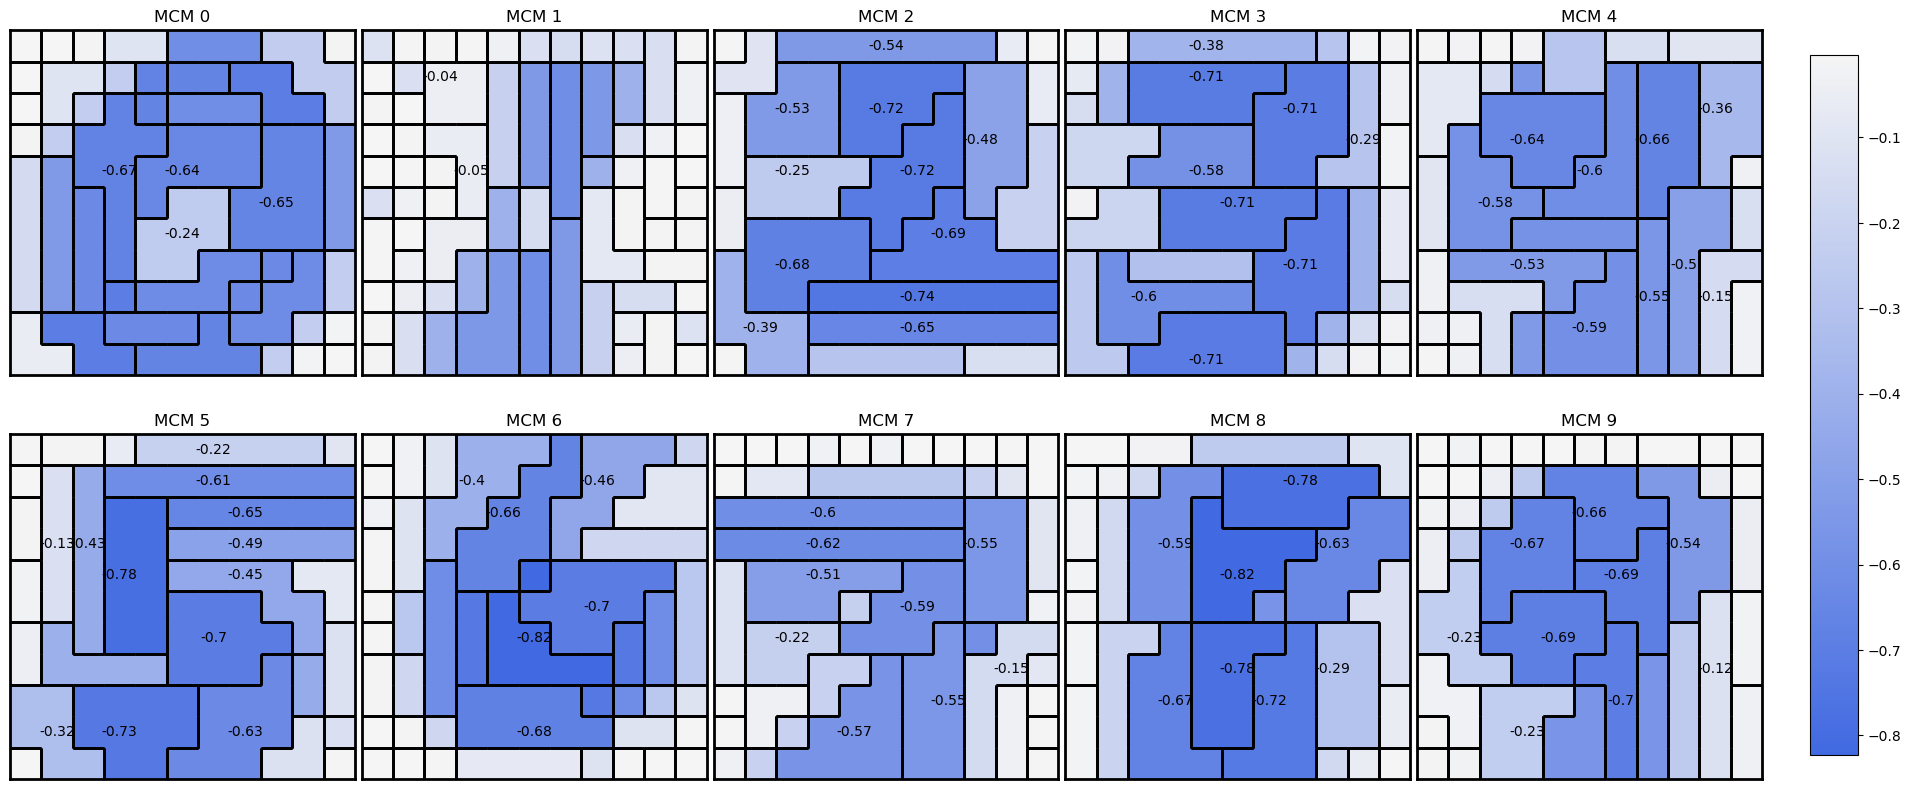

In [13]:




# for mcm_idxs in [[0,1,2,3],[4,5,6,7],[8,9,0,0]]:
scale = 2
fig, axs  = plt.subplots(2,5,figsize=(12*scale,5*scale))
axs = axs.flatten()



global_vbounds = np.min([np.min(i) for i in evds]), np.max([np.max(i) for i in evds])

for ax_i, mcm_idx in enumerate(mcm_idxs):
    val_matrix = evds[ax_i][comms[ax_i]]
    axs[ax_i].set_title("MCM %d" % (mcm_idx))
    im = myplot.partition_map(axs[ax_i],val_matrix,None,myplot.find_borders(comms[ax_i]),drawing_cond=lambda x: True,
                                normalise=False,global_vbounds=global_vbounds,cbar=False,cmap=cmap)    
    myplot.label_communities(comms[ax_i],axs[ax_i],evds[ax_i].round(2),color="black") 
                    
# fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
#                     wspace=0.02, hspace=0.02)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.83,
                    wspace=0.02, hspace=0.02)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.savefig("test.png", dpi=300, bbox_inches="tight")

fig.colorbar(im, cax=cbar_ax)
# plt.suptitle("Pixelwise log-evidence")
# plt.tight_layout()
plt.savefig("../figures/paper_evidence_pixelwise.png",dpi=300,bbox_inches="tight")



- Pixelwise log-evidence for each icc (/log(2)/nr_images/nr_pixel_in_icc)
- grey areas have highest values -> are most compressible ones
- may be that these areas are very indivative as they are usually not part of the digit. So if they are lit, then its likly not the same digit (see MCM1 vs MCM0 for example.)

In [ ]:
comms[0]

array([[ 0, 13, 18,  4,  4, 16, 11, 11,  8,  8,  0],
       [19,  4,  4, 16, 16, 21, 11, 11, 11,  8,  8],
       [ 1,  4, 16, 16, 21, 15, 15, 15, 11, 11,  8],
       [19, 16, 16, 21, 21, 15, 15, 15,  2, 11, 14],
       [ 3, 16, 12, 21, 21, 15, 15,  2,  2,  2, 14],
       [ 3, 12, 12, 21, 21, 10, 10,  2,  2,  2, 14],
       [ 3, 12, 12, 21, 10, 10, 10,  2,  7,  2, 14],
       [ 3, 12, 12, 20, 10, 10,  7,  7,  7,  7, 14],
       [20, 12, 20, 20,  7,  7,  7,  7,  7, 14, 17],
       [ 6, 20, 20,  5,  5,  5,  5,  5, 14, 17,  9],
       [13,  6, 20, 20,  5,  5,  5, 14, 17,  9,  1]])

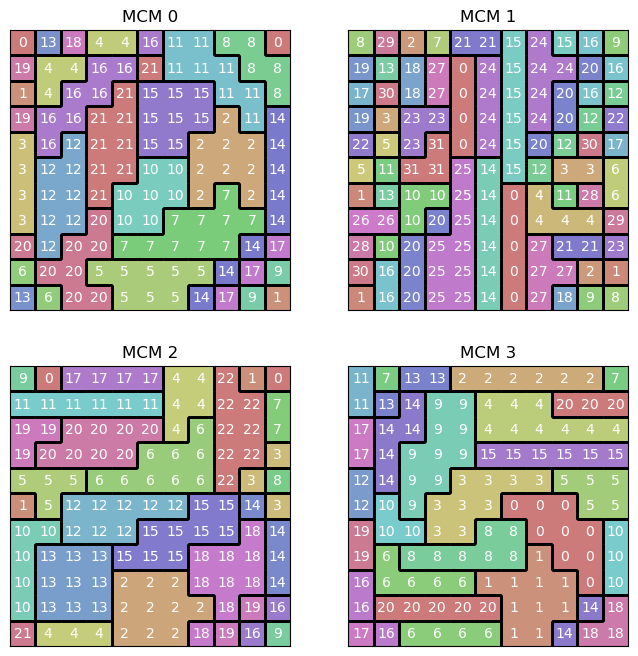

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs = axs.flatten()
for i in range(4):  
    myplot.plot_communities(axs[i],comms[i],f"MCM {i}")
plt.show()

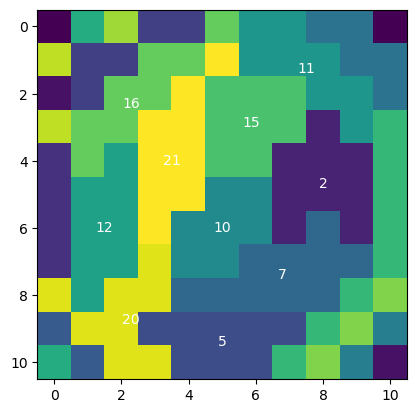

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as ndi

# Assuming `data` is your 2D numpy array
fig, ax = plt.subplots()
cax = ax.imshow(data, cmap='viridis')

communities = np.unique(data)

# Calculate the average size of the communities
average_size = np.mean([np.sum(data == community) for community in communities])

for community in communities:
    mask = data == community
    labeled_mask, num_labels = ndi.label(mask)


    sizes = ndi.sum(mask, labeled_mask, range(num_labels + 1)) # size largest connected component
    max_size = sizes.max()

    # only communities with 70% of the cells adjacent and community size larger than average
    if max_size / mask.sum() > 0.7 and mask.sum() > average_size:

        max_mask = labeled_mask == np.argmax(sizes)

        y, x = ndi.center_of_mass(max_mask)
        ax.text(x, y, str(community), color='white', ha='center', va='center')

plt.show()

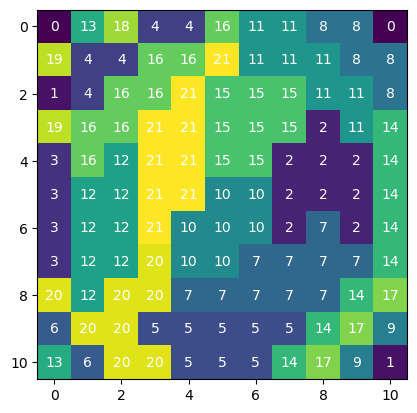

In [ ]:
plt.imshow(comms)
myplot.draw_all_values(comms)

In [ ]:

myplot.partition_map(plt.gca(),mi_matrix,mi_matrix,borders,drawing_cond=drawing_cond)  